# Awareness Modeling Using Matrix Factorization : LDA


In [1]:
%matplotlib inline
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import seaborn as sns
from scipy import sparse, stats, spatial
from pygsp import graphs, filters, plotting
from sklearn.decomposition import NMF, LatentDirichletAllocation
import json
import tqdm as tqdm

Import all the features (created in the SVR notebook)

In [2]:
features_df = pd.read_pickle("all_features_pos.pickle")

## Applying the LDA to the Standardized Features

Taking the standardized and positive feature vector we compute the Matrix factorization to extract the countries / topics matrix. 

(247, 186)


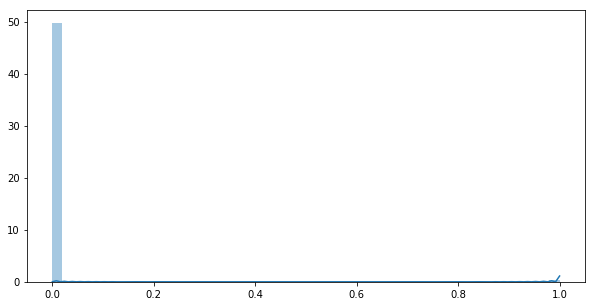

In [15]:
features_mat = features_df.as_matrix()

n_samples = np.shape(features_mat)[1]
n_features = len(features_df.columns)
n_components = round(np.shape(features_mat)[1]/8)

W = LatentDirichletAllocation(n_components=n_components, max_iter=20,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0).fit_transform(features_mat)

pkl_file = open("LDA_weights.pickle", 'wb')
pickle.dump(W,pkl_file)
pkl_file.close()

print(np.shape(W))
plt.figure(figsize=[10,5])
sns.distplot(W.flatten())

## Weight Matrix and Graph

Given the matrix W we can compute the distance between the different vectors and use that as the weights for the edges in our graph. 

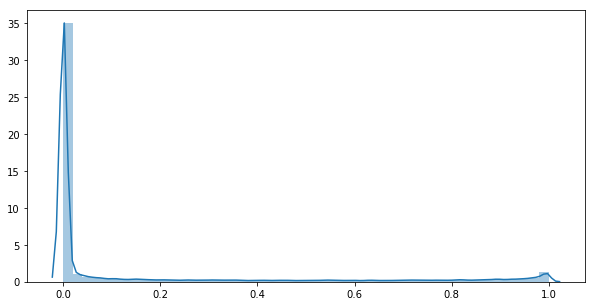

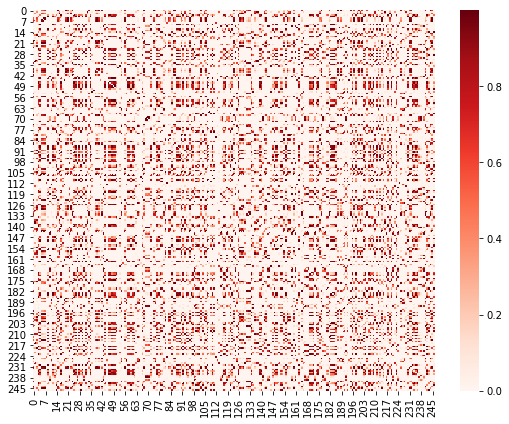

In [25]:
W = pickle.load(open('LDA_weights.pickle','rb'))
distances = spatial.distance.squareform(spatial.distance.pdist(W)) # W
#plt.figure(figsize=[9,7])
#sns.heatmap(distances)

kernel_width = np.mean(distances)- np.std(distances)#distances.mean()

def kernel(x):
    return np.exp(- np.power(x/kernel_width,2))

# applying the kernel to the distances matrix :
weights = kernel(distances)
# setting the diagonal (self-loops) weights to 0 :
weights[range(len(weights)),range(len(weights))] = 0

# displaying a subset of the weights matrix :

plt.figure(figsize=[10,5])
sns.distplot(weights.flatten())
plt.figure(figsize=[9,7])
sns.heatmap(weights,cmap="Reds")

In [26]:
# Get the position of the nodes
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))
c_data.drop("United States Minor Outlying Islands",inplace = True)

countries = c_data.index.tolist()

weights_df = pd.DataFrame(weights,columns=countries,index=countries)
weights_df.head()

,Aruba,Afghanistan,Angola,Anguilla,Åland Islands,Albania,Andorra,United Arab Emirates,Argentina,Armenia,...,British Virgin Islands,United States Virgin Islands,Vietnam,Vanuatu,Wallis and Futuna,Samoa,Yemen,South Africa,Zambia,Zimbabwe
Aruba,0.000000e+00,3.043151e-03,1.223436e-01,1.451202e-15,3.555541e-20,5.567480e-01,6.029323e-01,7.026129e-01,2.000984e-73,5.141192e-21,...,2.054763e-28,8.113274e-32,3.390407e-49,1.209515e-38,7.874332e-01,7.651899e-16,1.475598e-11,9.486568e-01,6.340498e-01,1.398921e-11
Afghanistan,3.043151e-03,0.000000e+00,3.995670e-01,7.359640e-06,1.063328e-08,6.746845e-02,5.634584e-02,3.734571e-02,6.871530e-49,3.060130e-09,...,3.097230e-14,1.212876e-16,1.266861e-29,1.268122e-21,2.277138e-04,5.044750e-06,1.242137e-03,9.558626e-04,4.975274e-02,1.208258e-03
Angola,1.223436e-01,3.995670e-01,0.000000e+00,4.057964e-09,1.157764e-12,6.261871e-01,5.799166e-01,4.811186e-01,4.760805e-58,2.533734e-13,...,2.835809e-19,4.457274e-22,8.282559e-37,8.589268e-28,2.335280e-02,2.505856e-09,3.497984e-06,5.965547e-02,5.489332e-01,3.367950e-06
Anguilla,1.451202e-15,7.359640e-06,4.057964e-09,0.000000e+00,4.881615e-01,6.204924e-12,3.575453e-12,1.058550e-12,1.415264e-22,3.754357e-01,...,1.028991e-02,1.067307e-03,2.128440e-10,4.829733e-06,3.767032e-18,9.970348e-01,4.844904e-01,9.402171e-17,2.459738e-12,4.889012e-01
Åland Islands,3.555541e-20,1.063328e-08,1.157764e-12,4.881615e-01,0.000000e+00,5.556535e-16,2.922138e-16,7.093669e-17,1.139034e-17,9.797702e-01,...,1.881550e-01,4.374316e-02,3.074396e-07,8.828863e-04,4.032796e-23,5.337726e-01,5.593788e-02,1.561488e-21,1.890421e-16,5.695995e-02


Checking to see the closest countries to Germany to see if the output is coherent

In [27]:
country = 'Germany'
weights_df[country].loc[weights_df[country] >= 0.9].sort_values(ascending = False)

Denmark                             0.999982
Comoros                             0.999887
Djibouti                            0.999356
Cambodia                            0.999290
Cape Verde                          0.999023
Slovakia                            0.998960
Moldova                             0.997673
Sweden                              0.993158
Micronesia                          0.989709
Peru                                0.989679
Cameroon                            0.983503
Pakistan                            0.982358
Iraq                                0.981002
Colombia                            0.977046
Barbados                            0.975175
Liberia                             0.963460
Turkmenistan                        0.951937
Bouvet Island                       0.942894
Uzbekistan                          0.939977
Belize                              0.937518
Republic of the Congo               0.936465
Italy                               0.929448
Venezuela 

Here we can already note quite a few incoherences as it is highly unlikely that an event in Germany would generate equal reactions in over 100 countries. 

## Creating the Graph And Use Heat Diffusion On The Graph To Estimate Levels Of Reaction

Nonetheless we use the graph diffusion to have a better visualization of the spread of reactions which we will then be able to see on the tweet-awareness.eu website

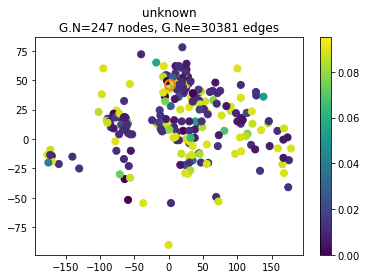

In [28]:

# Get the position of the nodes
c_data = pickle.load(open('../DataEnriching/data.pickle','rb'))
c_data.drop("United States Minor Outlying Islands",inplace = True)
countries = c_data.index.tolist()


weights_df = pd.DataFrame(weights,columns=countries,index=c_data.index.tolist())

country_pos = np.array(c_data[['latlng']].as_matrix())
country_pos = [ np.array(x[0]) for x in country_pos]
country_pos = np.vstack(country_pos)
country_pos = np.transpose(np.vstack((country_pos[:,1], country_pos[:,0])))

# Create the graph
G = graphs.Graph(weights_df.as_matrix())

G.set_coordinates(country_pos)
G.compute_fourier_basis()

# Create the heat diffusion filter
filt = filters.Heat(G, tau=100)


# Create the signal for a given country
for NODE, country in enumerate(weights_df.index):
    
    signal = np.zeros(G.N)
    signal[NODE] = 10

    # Apply the filter to the signal
    filtered_s = filt.filter(signal)
    
   
    if NODE > 0:
        filtered_signals = np.vstack((filtered_signals, filtered_s))
    else : 
        filtered_signals = filtered_s
    
    if country == "France":
        # Plot the signal on the graph
        G.plot_signal(filtered_s, vertex_size=50, highlight=NODE)

filtered_signals = np.transpose(filtered_signals)


Here we can see more clearly what is going on (with the dots placed at the center of each country). There does not seem to be any logic to the madness... To visualize this more clearly please refer to the interactive plot on the data-story.

## Exporting the results to a json which can be visualized on a map

In [30]:
diffusion_json = {}

country_names = c_data.ISO3.tolist()

diffusion_df = pd.DataFrame(filtered_signals, columns = country_names, index = country_names)

graph_diffusion_json = diffusion_df.to_json(force_ascii=False,orient='columns')


diffusion_json['graph_diffusion'] = dict(json.loads(graph_diffusion_json))

story_path = '../../../Data-Story/'
metrics_file = open(os.path.join(story_path,'III-Analysis','diffusion.json'), 'w')

json.dump(diffusion_json,metrics_file,separators=(',', ':'), indent=4)
metrics_file.close()
